# Arc crack under remote uniform isotropic tension in plane-strain

We consider a circular arc crack in a 2D plane-strain infinite uniform isotropic solid, undergoing deformation due to an isotropic tensile loading applied at infinity. Such a loading does not result in any local shear traction. Indeed, as $\bm{\sigma}=\bm{I}$, the local traction vector 
along the crack is along the local normal $\bm{T}=\bm{n}$. However, because the crack is non-planar, some induced shear traction by crack opening must be released, which results in some shear slip along the arc crack. Such a problem contains therefore both mode I (tensile) and mode II (shear) component, and is therefore a good benchmark. 

The solution can be found in A . Piva . A crack along a circular interface between dissimilar media. *Meccanica*, 17 (2) : 85-90, june 1982.
We code here the simpler case of an uniform media.

In [1]:
# imports etc.
import numpy as np
from scipy.sparse.linalg import gmres

from bigwham4py import BEMatrix

# for plotting
import matplotlib.pyplot as plt


In [2]:
# analytical solution from PIVA 1982

def ArcCrackIsotropicTension_dd(phi,theta,Ep=1,R=1,p=1):
    aux = -4*np.sqrt(2.)/Ep
    f = aux*R*np.exp(-0.5j*(2*theta+phi))*(-np.exp(1j*theta)+np.exp(1j*phi))*(-1+np.exp(1j*(theta+phi)))*np.emath.sqrt(1./(np.cos(phi)-np.cos(theta)))/(-3+np.cos(theta))
    return np.real(f),np.imag(f)

def ArcCrackIsotropicTension_SIF(theta,R=1,p=1):
    KI=p*np.emath.sqrt(np.pi*R*np.sin(theta))*np.cos(theta/2)/(1+np.sin(theta/2)**2)
    KII=np.abs(p*np.emath.sqrt(np.pi*R*np.sin(theta))*np.sin(theta/2)/(1+np.sin(theta/2)**2))
    return KI,KII 


In [3]:
# a function for the arc crack mesh
def ArcCrackMesh(theta,R=1,Ne=10):
    Angle = [-theta + (2*theta/Ne)*i for i in range(Ne+1)]
#  (* = Nbc+2*Nbt = Total Number of Elements per fracture,   for 2 crack tips per fracture *)
    coor = np.transpose(np.array((R*np.cos(Angle), R*np.sin(Angle))))
    conn = np.fromfunction(lambda i, j: i + j, (Ne, 2), dtype=np.int_) # the connectivity of the mesh is very simple 
    return coor,conn

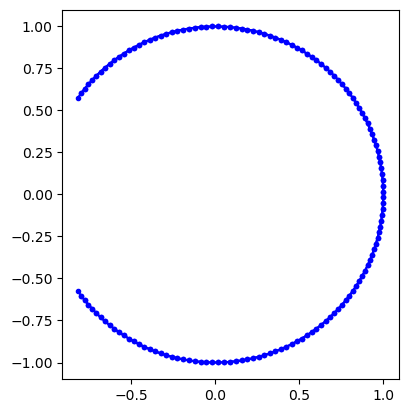

In [4]:
theta=145/180*np.pi
Nelts = 145 # we use 1 element for every 2 degree of arc
coor,conn=ArcCrackMesh(theta,R=1,Ne=Nelts)
plt.plot(coor[conn[:],0],coor[conn[:],1],'.-b')
plt.gca().set_aspect('equal')

We now solve the problem for an unit isotropic tension using piece-wise constant element in 2D. 

In [5]:
#elastic properties
nu = 0.2             # Poisson's ratio [-]
E =  2.4 # Young's modulus [Pa]
Ep = E/(1-nu**2)
elas_prop = np.array([E, nu]) # an array for the BigWham interface

# creation of H mat
kernel="2DP0-H"
h = BEMatrix(kernel,coor,conn,elas_prop,max_leaf_size=100,eta=3.,eps_aca=1.e-5)

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  7e-06
 binary cluster tree depth =1
 Number of blocks =4
 Number of full blocks =4
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.013638
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 3
Hierarchical matrix  construction time = :  0.013672
--------------------


In [6]:
# isotropic unit tension load results in a uniform normal traction on all elements, (with zero shear)
Tinf=np.zeros(2*Nelts)
Tinf[1::2]=1
#

jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
d = gmres(h,Tinf,M=jac_ilu,rtol=1e-6)[0]
dd = d.reshape((-1, 2))

# computing the analytical solution at the centroid of each element where DD are located for P0 element
col_pts=h.getCollocationPoints()
phi=np.arctan2(col_pts[:,1],col_pts[:,0])

(dn,ds)=ArcCrackIsotropicTension_dd(phi,theta,Ep=Ep,R=1,p=1)


Text(0, 0.5, 'Fracture aperture  ')

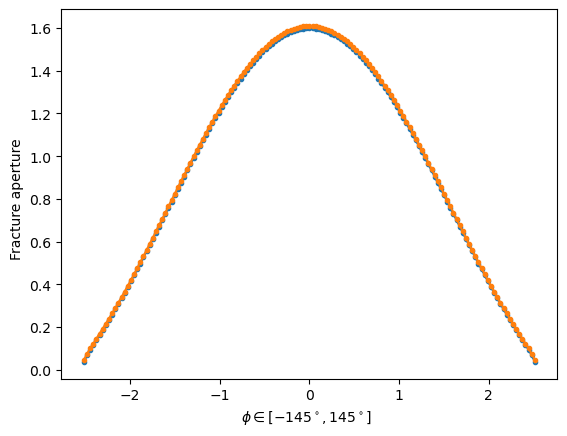

In [7]:
plt.plot(phi,dn,'.-')
plt.plot(phi,dd[:,1],'.-')
plt.xlabel('$\phi \in [-145^\circ, 145^\circ]$  ')
plt.ylabel('Fracture aperture  ')

Text(0, 0.5, 'Fracture shear displacement discontinuity (slip) ')

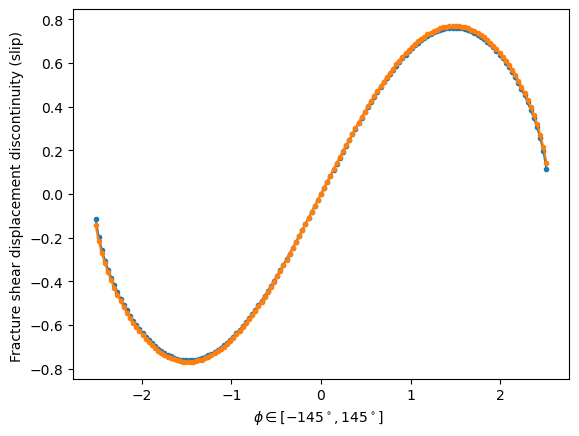

In [8]:
plt.plot(phi,ds,'.-')
plt.plot(phi,dd[:,0],'.-')
plt.xlabel('$\phi \in [-145^\circ, 145^\circ]$  ')
plt.ylabel('Fracture shear displacement discontinuity (slip) ')

We compute the L2 relative error, for both the opening and shear component of the fracture displacement discontinuity.

In [9]:
(np.linalg.norm(dn-dd[:,1])/np.linalg.norm(dn),np.linalg.norm(ds-dd[:,0])/np.linalg.norm(ds))

(0.008070816829665433, 0.014197253121581847)

We can estimate the SIF at the tip assuming that the displacement of the tip element is following  LEFM asymptote: 
$$ \Delta u_i (x) = \dfrac{K_i}{E^\prime} \sqrt{32/\pi} \sqrt{x} $$ 

for $\ell-x \ll 1 $, where $\ell$ is the fracture length.
Such an evaluation is not great for piece-wise constant element, even when averaging the displacement of the 2 neighbouring tip element.

<!---
$\Delta u_i (x)= (1/h) \int_0^h \dfrac{K_i}{E^\prime}  \sqrt{32/\pi} \sqrt{x}  d x$ such that 

$$K_i = \Delta u_i(h/2) * E' / (\sqrt{32/\pi} * 2/3 \sqrt{h} )$$ 
with $h$ the element size. 
--->


In [10]:
h_x=np.linalg.norm(coor[1]-coor[0])
# from integral of the asymptote over the last element
#K1_num = np.abs(dd[0,1])* Ep / (np.sqrt(32./np.pi)*(2/3)*np.sqrt(h_x))
#K2_num = np.abs(dd[0,0])* Ep / (np.sqrt(32./np.pi)*(2/3)*np.sqrt(h_x))

# from dd of the last element
K1_num = np.abs(dd[0,1])* Ep / (np.sqrt(32./np.pi)*np.sqrt(h_x/2))
K2_num = np.abs(dd[0,0])* Ep / (np.sqrt(32./np.pi)*np.sqrt(h_x/2))

# from average dd of the last 2 elements
K1_num = np.abs(0.5*(dd[0,1]+dd[1,1]))* Ep / (np.sqrt(32./np.pi)*np.sqrt(1*h_x))
K2_num = np.abs(0.5*(dd[0,0]+dd[1,0]))* Ep / (np.sqrt(32./np.pi)*np.sqrt(1*h_x))

(K1_ref,K2_ref)=ArcCrackIsotropicTension_SIF(theta)

(np.abs(1-(K1_num/K1_ref)),np.abs(1-(K2_num/K2_ref)))

(0.22174698329559073, 0.1252675544466444)